In [2]:
import pyspark
print(pyspark.__version__)

2.4.0


In [3]:
from pyspark.sql import SparkSession

# Buat SparkSession dengan Hive support
spark = SparkSession.builder \
    .appName("LogAnalysis") \
    .master("spark://spark-master:7077") \
    .config("spark.sql.catalogImplementation", "hive") \
    .config("hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

2025-06-19 06:24:43 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
spark.sql("SHOW DATABASES").show()
spark.sql("SHOW TABLES").show()

+------------+
|databaseName|
+------------+
|     default|
+------------+

+--------+-----------+-----------+
|database|  tableName|isTemporary|
+--------+-----------+-----------+
| default|logs_parsed|      false|
| default|   logs_raw|      false|
+--------+-----------+-----------+



In [5]:
# Baca tabel logs_parsed
logs = spark.table("logs_parsed")
logs.createOrReplaceTempView("logs")

In [9]:
spark.sql("""
  SELECT *
  FROM logs
  LIMIT 10
""").show()

+-------------+--------+----+--------------------+------+--------------------+--------+------+-----+--------------------+--------------------+
|           ip|identity|user|           timestamp|method|            endpoint|protocol|status| size|             referer|          user_agent|
+-------------+--------+----+--------------------+------+--------------------+--------+------+-----+--------------------+--------------------+
| 54.36.149.41|       -|   -|22/Jan/2019:03:56...|   GET|/filter/27|13%20%...|HTTP/1.1|   200|30577|                   -|Mozilla/5.0 (comp...|
|  31.56.96.51|       -|   -|22/Jan/2019:03:56...|   GET|/image/60844/prod...|HTTP/1.1|   200| 5667|https://www.zanbi...|Mozilla/5.0 (Linu...|
|  31.56.96.51|       -|   -|22/Jan/2019:03:56...|   GET|/image/61474/prod...|HTTP/1.1|   200| 5379|https://www.zanbi...|Mozilla/5.0 (Linu...|
|40.77.167.129|       -|   -|22/Jan/2019:03:56...|   GET|/image/14925/prod...|HTTP/1.1|   200| 1696|                   -|Mozilla/5.0 (comp...|

In [10]:
# Contoh Analisis: Frekuensi Akses Tiap Jam
from pyspark.sql.functions import hour, to_timestamp

# Ubah timestamp string ke TimestampType kemudian ekstrak jam
df_time = logs.withColumn("parsed_ts", to_timestamp("timestamp", "dd/MMM/yyyy:HH:mm:ss Z")) \
              .withColumn("hour", hour("parsed_ts"))
df_time.createOrReplaceTempView("logs_with_hour")

spark.sql("""
SELECT hour, 
       COUNT(*) AS total_requests,
       SUM(CASE WHEN status >= 400 THEN 1 ELSE 0 END) AS errors
FROM logs_with_hour
GROUP BY hour
ORDER BY hour
""").show()

[Stage 5:==============================>                       (114 + 16) / 200]

+----+--------------+------+
|hour|total_requests|errors|
+----+--------------+------+
|null|            77|     0|
|   0|         75720|  1781|
|   1|         73026|  1542|
|   2|         74082|  1780|
|   3|        125561|  2309|
|   4|        282566|  3975|
|   5|        473158|  6206|
|   6|        627241|  8907|
|   7|        707421|  9653|
|   8|        729521| 10664|
|   9|        728069| 11142|
|  10|        714430| 10557|
|  11|        671298| 11651|
|  12|        606140| 10802|
|  13|        564234|  9477|
|  14|        545806| 10731|
|  15|        573689| 16382|
|  16|        556140| 10868|
|  17|        395114|  6878|
|  18|        455347|  7408|
+----+--------------+------+
only showing top 20 rows



In [11]:
# Contoh Analisis: Top User Agent
spark.sql("""
  SELECT user_agent, COUNT(*) AS hits
  FROM logs
  GROUP BY user_agent
  ORDER BY hits DESC
  LIMIT 10
""").show()

[Stage 7:==================================================>   (186 + 13) / 200]

+--------------------+------+
|          user_agent|  hits|
+--------------------+------+
|Mozilla/5.0 (Wind...|746557|
|Mozilla/5.0 (Wind...|702494|
|Mozilla/5.0 (Wind...|636882|
|Mozilla/5.0 (Wind...|552139|
|Mozilla/5.0 (Wind...|454960|
|Mozilla/5.0 (Linu...|450555|
|Mozilla/5.0 (Wind...|340969|
|Mozilla/5.0 (comp...|197769|
|Mozilla/5.0 (comp...|191450|
|Mozilla/5.0 (iPho...|180000|
+--------------------+------+



In [12]:
import time

start_time = time.time()

# Perbandingan dengan Hive: Query 1
spark.sql("""
SELECT ip, COUNT(*) AS hits
FROM logs_parsed
GROUP BY ip
ORDER BY hits DESC
LIMIT 10
""").show()

end_time = time.time()

print(f"Query 1 execution time: {end_time - start_time:.2f} seconds")

[Stage 10:======================================>              (146 + 12) / 200]

+---------------+------+
|             ip|  hits|
+---------------+------+
|  66.249.66.194|353483|
|   66.249.66.91|314522|
|151.239.241.163| 92473|
|   66.249.66.92| 88332|
|    91.99.30.32| 45973|
|  104.222.32.91| 42058|
|    91.99.72.15| 38694|
|    91.99.47.57| 38609|
|   5.78.190.233| 37203|
|195.181.168.181| 27979|
+---------------+------+

Query 1 execution time: 24.91 seconds


In [13]:
start_time = time.time()

# Perbandingan dengan Hive: Query 2
spark.sql("""
SELECT status, COUNT(*) AS count
FROM logs_parsed
GROUP BY status
ORDER BY count DESC
""").show()

end_time = time.time()

print(f"Query 2 execution time: {end_time - start_time:.2f} seconds")

[Stage 12:=====================================================>  (25 + 1) / 26]

+------+-------+
|status|  count|
+------+-------+
|   200|9579824|
|   304| 340228|
|   302| 199835|
|   404| 105011|
|   301|  67553|
|   499|  50852|
|   500|  14266|
|   403|   5634|
|   502|    798|
|   400|    527|
|   401|    323|
|   408|    112|
|   504|    103|
|  null|     77|
|   405|      6|
|   206|      3|
+------+-------+

Query 2 execution time: 22.95 seconds


In [14]:
start_time = time.time()

# Perbandingan dengan Hive: Query 3
spark.sql("""
SELECT endpoint, COUNT(*) AS views
FROM logs_parsed
GROUP BY endpoint
ORDER BY views DESC
LIMIT 10
""").show()

end_time = time.time()

print(f"Query 3 execution time: {end_time - start_time:.2f} seconds")

[Stage 15:=================================================>   (187 + 12) / 200]

+--------------------+------+
|            endpoint| views|
+--------------------+------+
|      /settings/logo|352047|
|/static/css/font/...|280176|
|/static/images/gu...|138010|
|/static/images/gu...|125689|
|/static/images/gu...|124127|
|/static/images/gu...|116653|
|/site/alexaGooleA...|103798|
|        /favicon.ico|102731|
|/static/images/gu...| 98460|
|/static/images/am...| 92409|
+--------------------+------+

Query 3 execution time: 28.00 seconds


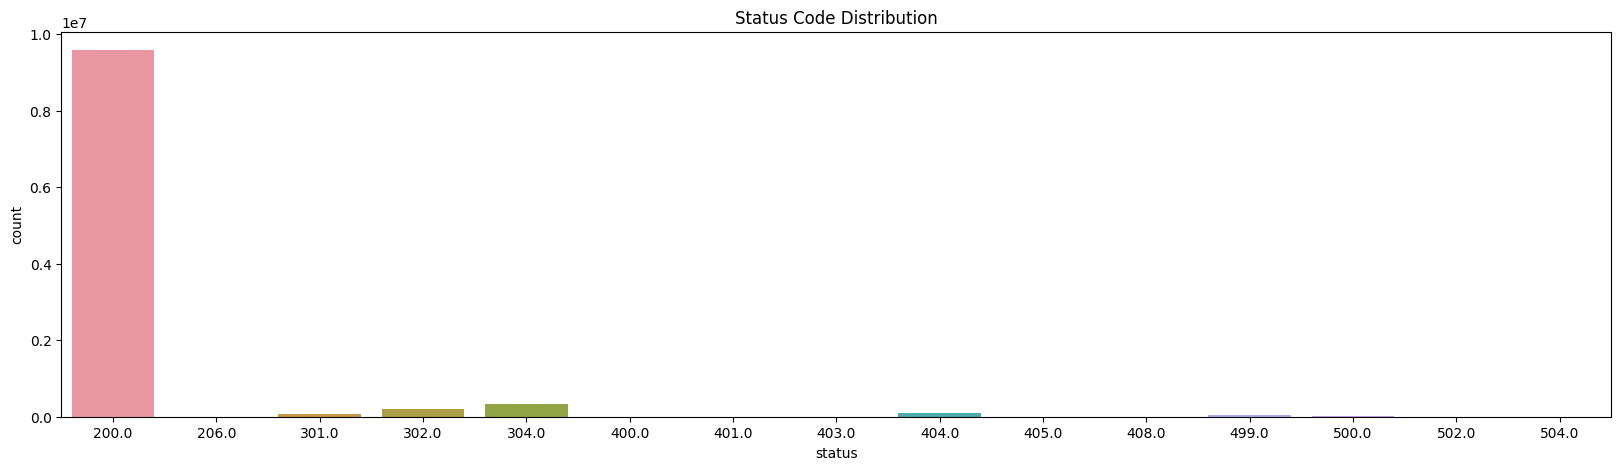

In [18]:
# Konversi ke Pandas untuk plotting
pdf = spark.sql("""
  SELECT status, COUNT(*) AS count
  FROM logs
  GROUP BY status
""").toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
sns.barplot(x='status', y='count', data=pdf)
plt.title("Status Code Distribution")
plt.show()